# Part 4: Quantization

## Load  CIFAR10 dataset from tf.keras

In [1]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

2021-11-30 03:07:38.270551: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2021-11-30 03:07:38.270582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Let's print some information about the dataset
Print the the dataset shape

In [2]:
print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 10) (10000, 10)


## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and recently support for QKeras model is added to hls4ml.

In [3]:
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qconvolutional import QConv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten,InputLayer, MaxPooling2D, Activation

input_shape=( 32, 32, 3)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(QConv2D(16, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(QConv2D(16, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(QConv2D(8, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(QConv2D(8, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(QDense(10,kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(Activation(activation='softmax'))

model.build()
model.summary()


2021-11-30 03:07:42.907327: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2021-11-30 03:07:42.907354: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-30 03:07:42.907388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ECE-util1): /proc/driver/nvidia/version does not exist
2021-11-30 03:07:42.907664: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with t

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d (QConv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
q_activation (QActivation)   (None, 30, 30, 16)        0         
_________________________________________________________________
q_conv2d_1 (QConv2D)         (None, 28, 28, 16)        2320      
_________________________________________________________________
q_activation_1 (QActivation) (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
q_conv2d_2 (QConv2D)         (None, 12, 12, 8)         1160      
_________________________________________________________________
q_activation_2 (QActivation) (None, 12, 12, 8)         0

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [4]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=0, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)


Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_mnist_cnn4'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [13]:
from tensorflow.keras.optimizers import Adam
from callbacks import all_callbacks

train = True


if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_cifar10_cnn')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(x_train, y_train, batch_size=128,
              epochs=200, validation_split=0.2, shuffle=True,
              callbacks = callbacks.callbacks)
    model = strip_pruning(model)
    model.save('model_cifar10_cnn/KERAS_check_best_model.h5')
else:
    from qkeras.utils import load_qmodel
    model = load_qmodel('model_cifar10_cnn/KERAS_check_best_model.h5')

2021-12-02 01:20:06.489221: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-12-02 01:20:07.226135: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/200
  1/313 [..............................] - ETA: 0s - loss: 1.5980 - accuracy: 0.3516

2021-12-02 01:20:09.112291: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


  2/313 [..............................] - ETA: 1:17 - loss: 1.5890 - accuracy: 0.3789WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0462s vs `on_train_batch_end` time: 0.4550s). Check your callbacks.


2021-12-02 01:20:09.363365: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_cifar10_cnn/logs/train/plugins/profile/2021_12_02_01_20_09
2021-12-02 01:20:09.386325: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to model_cifar10_cnn/logs/train/plugins/profile/2021_12_02_01_20_09/ECE-util1.trace.json.gz
2021-12-02 01:20:09.438190: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_cifar10_cnn/logs/train/plugins/profile/2021_12_02_01_20_09
2021-12-02 01:20:09.456292: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to model_cifar10_cnn/logs/train/plugins/profile/2021_12_02_01_20_09/ECE-util1.memory_profile.json.gz
2021-12-02 01:20:09.608668: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: model_cifar10_cnn/logs/train/plugins/profile/2021_12_02_01_20_09Dumped tool data fo

311/313 [============================>.] - ETA: 0s - loss: 1.6224 - accuracy: 0.3949
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00001: val_loss improved from inf to 1.50582, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.50582, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00001: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 12s 39ms/step - loss: 1.6222 - accuracy: 0.3948 - val_loss: 1.5058 - val_accuracy: 0.4535
Epoch 2/200
313/313 [==============================] - ETA: 0s - loss: 1.6019 - accuracy: 0.4064
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00002: val_loss improved from 1.50582 to 1.48430, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00002: val_loss improved 

313/313 [==============================] - ETA: 0s - loss: 1.5057 - accuracy: 0.4473
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00013: val_loss improved from 1.42210 to 1.41123, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 1.42210 to 1.41123, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00013: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 36ms/step - loss: 1.5057 - accuracy: 0.4473 - val_loss: 1.4112 - val_accuracy: 0.4876
Epoch 14/200
313/313 [==============================] - ETA: 0s - loss: 1.5061 - accuracy: 0.4482
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00014: val_loss did not improve from 1.41123

Epoch 00014: val_loss did not improve from 1.41123

Epoch 00014: saving model to model_

Epoch 26/200
313/313 [==============================] - ETA: 0s - loss: 1.4612 - accuracy: 0.4676
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00026: val_loss improved from 1.37603 to 1.36661, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 1.37603 to 1.36661, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00026: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00026: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 37ms/step - loss: 1.4612 - accuracy: 0.4676 - val_loss: 1.3666 - val_accuracy: 0.5058
Epoch 27/200
313/313 [==============================] - ETA: 0s - loss: 1.4519 - accuracy: 0.4745
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00027: val_loss improved from 1.36661 to 1.36475, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 000

Epoch 39/200
312/313 [============================>.] - ETA: 0s - loss: 1.4262 - accuracy: 0.4814
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00039: val_loss did not improve from 1.34308

Epoch 00039: val_loss did not improve from 1.34308

Epoch 00039: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00039: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 12s 38ms/step - loss: 1.4259 - accuracy: 0.4815 - val_loss: 1.3435 - val_accuracy: 0.5133
Epoch 40/200
313/313 [==============================] - ETA: 0s - loss: 1.4224 - accuracy: 0.4818
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00040: val_loss improved from 1.34308 to 1.34060, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00040: val_loss improved from 1.34308 to 1.34060, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00040: saving mo

Epoch 52/200
313/313 [==============================] - ETA: 0s - loss: 1.4031 - accuracy: 0.4929
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00052: val_loss did not improve from 1.31022

Epoch 00052: val_loss did not improve from 1.31022

Epoch 00052: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00052: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 12s 38ms/step - loss: 1.4031 - accuracy: 0.4929 - val_loss: 1.3259 - val_accuracy: 0.5257
Epoch 53/200
312/313 [============================>.] - ETA: 0s - loss: 1.4022 - accuracy: 0.4912
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00053: val_loss did not improve from 1.31022

Epoch 00053: val_loss did not improve from 1.31022

Epoch 00053: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00053: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***c

313/313 [==============================] - ETA: 0s - loss: 1.3761 - accuracy: 0.5005
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00065: val_loss improved from 1.29804 to 1.29303, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00065: val_loss improved from 1.29804 to 1.29303, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00065: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00065: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.3761 - accuracy: 0.5005 - val_loss: 1.2930 - val_accuracy: 0.5395
Epoch 66/200
313/313 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.5032
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00066: val_loss improved from 1.29303 to 1.28670, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00066: val_loss 

Epoch 79/200
313/313 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.5053
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00079: val_loss did not improve from 1.27222

Epoch 00079: val_loss did not improve from 1.27222

Epoch 00079: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00079: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 36ms/step - loss: 1.3617 - accuracy: 0.5053 - val_loss: 1.2742 - val_accuracy: 0.5417
Epoch 80/200
313/313 [==============================] - ETA: 0s - loss: 1.3528 - accuracy: 0.5108
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00080: val_loss did not improve from 1.27222

Epoch 00080: val_loss did not improve from 1.27222

Epoch 00080: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00080: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

Epoc

Epoch 93/200
311/313 [============================>.] - ETA: 0s - loss: 1.3397 - accuracy: 0.5150
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00093: val_loss improved from 1.25691 to 1.24671, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00093: val_loss improved from 1.25691 to 1.24671, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00093: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00093: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.3397 - accuracy: 0.5150 - val_loss: 1.2467 - val_accuracy: 0.5617
Epoch 94/200
311/313 [============================>.] - ETA: 0s - loss: 1.3384 - accuracy: 0.5161
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00094: val_loss did not improve from 1.24671

Epoch 00094: val_loss did not improve from 1.24671

Epoch 00094: saving mo

Epoch 107/200
313/313 [==============================] - ETA: 0s - loss: 1.3225 - accuracy: 0.5215
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00107: val_loss did not improve from 1.23851

Epoch 00107: val_loss did not improve from 1.23851

Epoch 00107: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00107: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.3225 - accuracy: 0.5215 - val_loss: 1.2503 - val_accuracy: 0.5563
Epoch 108/200
311/313 [============================>.] - ETA: 0s - loss: 1.3258 - accuracy: 0.5202
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00108: val_loss did not improve from 1.23851

Epoch 00108: val_loss did not improve from 1.23851

Epoch 00108: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00108: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

**

Epoch 121/200
311/313 [============================>.] - ETA: 0s - loss: 1.3163 - accuracy: 0.5236
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00121: val_loss did not improve from 1.23046

Epoch 00121: val_loss did not improve from 1.23046

Epoch 00121: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00121: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.3164 - accuracy: 0.5234 - val_loss: 1.2350 - val_accuracy: 0.5591
Epoch 122/200
313/313 [==============================] - ETA: 0s - loss: 1.3150 - accuracy: 0.5269
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00122: val_loss did not improve from 1.23046

Epoch 00122: val_loss did not improve from 1.23046

Epoch 00122: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00122: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

**

Epoch 134/200
313/313 [==============================] - ETA: 0s - loss: 1.3041 - accuracy: 0.5320
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00134: val_loss improved from 1.22103 to 1.21807, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00134: val_loss improved from 1.22103 to 1.21807, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00134: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00134: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.3041 - accuracy: 0.5320 - val_loss: 1.2181 - val_accuracy: 0.5652
Epoch 135/200
313/313 [==============================] - ETA: 0s - loss: 1.3071 - accuracy: 0.5282
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00135: val_loss did not improve from 1.21807

Epoch 00135: val_loss did not improve from 1.21807

Epoch 00135: saving 

Epoch 148/200
311/313 [============================>.] - ETA: 0s - loss: 1.2945 - accuracy: 0.5330
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00148: val_loss improved from 1.21310 to 1.21179, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00148: val_loss improved from 1.21310 to 1.21179, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00148: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00148: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.2948 - accuracy: 0.5328 - val_loss: 1.2118 - val_accuracy: 0.5732
Epoch 149/200
311/313 [============================>.] - ETA: 0s - loss: 1.3028 - accuracy: 0.5322
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00149: val_loss improved from 1.21179 to 1.20964, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 0

Epoch 162/200
313/313 [==============================] - ETA: 0s - loss: 1.2926 - accuracy: 0.5351
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00162: val_loss improved from 1.20964 to 1.20637, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 00162: val_loss improved from 1.20964 to 1.20637, saving model to model_cifar10_cnn/KERAS_check_best_model_weights.h5

Epoch 00162: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00162: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.2926 - accuracy: 0.5351 - val_loss: 1.2064 - val_accuracy: 0.5715
Epoch 163/200
313/313 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.5345
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00163: val_loss improved from 1.20637 to 1.20228, saving model to model_cifar10_cnn/KERAS_check_best_model.h5

Epoch 0

313/313 [==============================] - ETA: 0s - loss: 1.2896 - accuracy: 0.5319
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00175: val_loss did not improve from 1.20169

Epoch 00175: val_loss did not improve from 1.20169

Epoch 00175: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00175: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.2896 - accuracy: 0.5319 - val_loss: 1.2253 - val_accuracy: 0.5629
Epoch 176/200
311/313 [============================>.] - ETA: 0s - loss: 1.2886 - accuracy: 0.5358
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00176: val_loss did not improve from 1.20169

Epoch 00176: val_loss did not improve from 1.20169

Epoch 00176: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00176: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end

Epoch 189/200
313/313 [==============================] - ETA: 0s - loss: 1.2878 - accuracy: 0.5345
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00189: val_loss did not improve from 1.19777

Epoch 00189: val_loss did not improve from 1.19777

Epoch 00189: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00189: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 11s 34ms/step - loss: 1.2878 - accuracy: 0.5345 - val_loss: 1.2151 - val_accuracy: 0.5694
Epoch 190/200
311/313 [============================>.] - ETA: 0s - loss: 1.2800 - accuracy: 0.5374
***callbacks***
saving losses to model_cifar10_cnn/losses.log

Epoch 00190: val_loss did not improve from 1.19777

Epoch 00190: val_loss did not improve from 1.19777

Epoch 00190: saving model to model_cifar10_cnn/KERAS_check_model_last.h5

Epoch 00190: saving model to model_cifar10_cnn/KERAS_check_model_last_weights.h5

Ep

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [17]:
import hls4ml
from hls4ml.converters.keras_to_hls import keras_to_hls
import plotting
import yaml

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'



config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['Backend']='VivadoAccelerator'
config['OutputDir'] = 'cifar10-hls-test-1'
config['ProjectName'] = 'myproject_cifar10_cnn4'
config['XilinxPart']= 'xczu7ev-ffvc1156-2-e'
config['Board'] = 'zcu104'
config['ClockPeriod'] = 5
config['IOType'] = 'io_stream'
config['HLSConfig']={}
config['HLSConfig']['Model']={}
config['HLSConfig']['Model']=config['Model']
config['HLSConfig']['LayerName']=config['LayerName']

del config['Model']
del config['LayerName']
config['AcceleratorConfig']={}
config['AcceleratorConfig']['Interface'] = 'axi_stream'
config['AcceleratorConfig']['Driver'] = 'python'
config['AcceleratorConfig']['Precision']={}
config['AcceleratorConfig']['Precision']['Input']= 'float'
config['AcceleratorConfig']['Precision']['Output']= 'float'
config['KerasModel'] = model



print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = keras_to_hls(config)
hls_model.compile()
x_test = np.ascontiguousarray(x_test)  #add more
y_qkeras = model.predict(x_test)
y_hls = hls_model.predict(x_test)

Interpreting Sequential
Topology:
Layer name: input_1, layer type: Input
Layer name: q_conv2d, layer type: QConv2D
Layer name: q_activation, layer type: QActivation
Layer name: q_conv2d_1, layer type: QConv2D
Layer name: q_activation_1, layer type: QActivation
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: q_conv2d_2, layer type: QConv2D
Layer name: q_activation_2, layer type: QActivation
Layer name: q_conv2d_3, layer type: QConv2D
Layer name: q_activation_3, layer type: QActivation
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: q_dense, layer type: QDense
Layer name: activation, layer type: Activation
-----------------------------------
Configuration
Backend:             VivadoAccelerator
OutputDir:           cifar10-hls-test-1
ProjectName:         myproject_cifar10_cnn4
XilinxPart:          xczu7ev-ffvc1156-2-e
Board:               zcu104
ClockPeriod:         5
IOType:              io_stream
HLSConfig
  Model
    Precision:       ap_fixed<16,6>
   

In [18]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from qkeras.utils import load_qmodel

model_ref = load_qmodel('model_cifar10_cnn/KERAS_check_best_model.h5')
y_ref = model_ref.predict(x_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))


Accuracy baseline:  0.5798
Accuracy pruned, quantized: 0.5798
Accuracy hls4ml: 0.5745


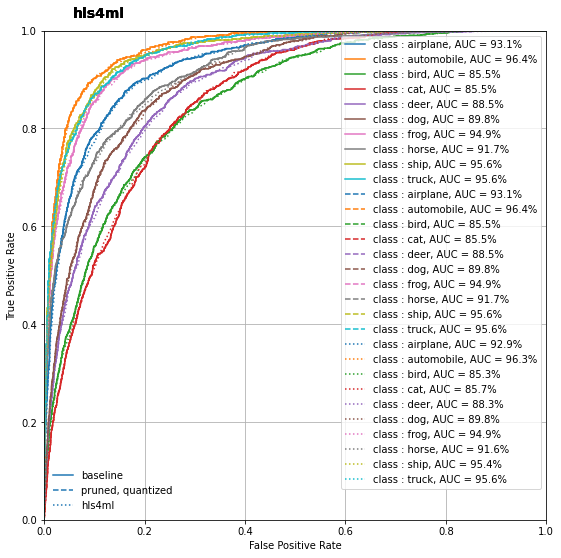

In [19]:
import matplotlib.pyplot as plt
mnist_classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, mnist_classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, mnist_classes, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls,mnist_classes, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'],
            loc='lower left', frameon=False)
ax.add_artist(leg)

# Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f mnist-hls-test4/vivado_hls.log`

In [20]:
import os
os.environ['PATH'] = '/workspace/home/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
hls_model.build(csim=False,synth=True,export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /workspace/home/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/workspace/home/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
/workspace/home/Xilinx/Vivado/2019.2/tps/tcl/tcl8.5/tzdata/America/Denver can't be opened.
INFO: [HLS 200-10] For user 'vitis-ai-user' on host 'eceutil1.gpu.snuhpc' (Linux_x86_64 version 4.15.0-76-generic) on Thu Dec 02 02:23:40 MST 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/workspace/home/hientt/Lab_8/cifar10-hls-test-1'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/workspace/home/hientt/Lab_8/cifar10-hls-test-1/myproject_cifar10_cnn4_prj'.
INFO: [HLS 200-10] Adding design file 'firmware

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config7>' (firmware/nnet_utils/nnet_activation_stream.h:69).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config7>' (firmware/nnet_utils/nnet_activation_stream.h:69).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>::operator[]' into 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, linear_config6>' (firmware/nnet_utils/nnet_activation_stream.h:4

INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config9>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config9>' (firmware/nnet_utils/nnet_conv2d_stream.h:103).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, relu_config14>' (firmware/nnet_utils/nnet_activation_stream.h:69).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>::operator[]' into 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 200u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, config17>' (firmware/nnet_utils/nnet_dense_stream.h:62).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>::operator[]' into 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config19>' (firmware/nnet_utils/nnet_activation_stream.h:156).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>::operator[]' into 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>, linear_config18>' (firmware/nnet_utils/nnet_activatio

INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 4, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 8, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' (firmware/nnet_utils/nnet_common.h:55) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 8, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 10, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' (firmware/nnet_utils/nnet_common.h:55) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 10, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReadInputWidth' (firmware/nnet_utils/nnet_pooling_stream.h:234) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config15>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReadInputWidth' (firmware/nnet_utils/nnet_pooling_stream.h:234) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'LinearActLoop' (firmware/nnet_utils/nnet_activation_stream.h:38) in function 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, linear_config13>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'Line

INFO: [HLS 200-489] Unrolling loop 'FiltLoop' (firmware/nnet_utils/nnet_pooling_stream.h:186) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'PoolLoop' (firmware/nnet_utils/nnet_pooling_stream.h:190) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'LinearPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:45) in function 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, linear_config13>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'LinearPackLoop' (firmware/nnet_utils/nnet_activation_stream.

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:120) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (firmware/nnet_utils/nnet_conv_stream.h:282) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-1.1.1' (firmware/nnet_utils/nnet_conv_stream.h:258) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config9>' completely with a factor of 143.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:85) in function 'nnet::conv

INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:226) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:228) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:187) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:189) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolli

INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer20_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:118) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer13_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:106) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer14_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:110) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer10_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:94) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer11_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:98) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer6_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:78) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer7_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:82) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer3_out.V.data.V' (fi

INFO: [XFORM 203-101] Partitioning array 'layer6_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:78) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer7_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:82) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer3_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:66) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer4_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:70) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer8_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:86) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer12_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:102) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer9_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:90) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer5_out.V.data.V' (firmware/myprojec

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12_mult>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config12>' (firmware/nnet_utils/nnet_dense_latency.h:125->firmware/nnet_utils/nnet_conv_stream.h:276->firmware/nnet_utils/nnet_conv2d_stream.h:85->firmware/nnet_utils/nnet_conv2d_stream.h:103) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 4, nnet::Op_max<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config15>' (firmware/nnet_utils/nnet_pooling_stream.h:22->firmware/nnet_utils/nnet_pooling_stream.h:195->firmware/nnet_utils/nnet_pooling_stream.h:238->fir

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:60:74) to (firmware/nnet_utils/nnet_activation_stream.h:60:68) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config4>'... converting 49 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_common.h:55:43) in function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 4, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >'... converting 5 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_common.h:53:17) in function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >'... converting 5 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (f

INFO: [HLS 200-472] Inferring partial write operation for 'out_data.data.V' (firmware/nnet_utils/nnet_stream.h:88:42)
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:13:00 ; elapsed = 00:15:56 . Memory (MB): peak = 6586.586 ; gain = 6155.066 ; free physical = 11907 ; free virtual = 168179
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_cifar10_cnn4_axi' ...


INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc541' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 959.33 seconds; current allocated memory: 894.375 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.99 seconds; current allocated memory: 894.813 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_3u_config2_s' 
INFO: [HLS 200-10] ------------------------------------------------

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 38.82 seconds; current allocated memory: 961.851 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'linear_array_array_ap_fixed_16u_linear_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'LinearActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 31.02 seconds; current allocated memory: 963.495 MB.
INFO: [BIND 205-100] Sta

INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed,8u>,config12>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.29 seconds; current allocated memory: 1013.820 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.38 seconds; current allocated memory: 1014.389 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_array_ap_fixed_8u_config12_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting schedulin

INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 3.8 seconds; current allocated memory: 1.086 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'linear_array_array_ap_fixed_10u_linear_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'linear<array,array<ap_fixed,10u>,linear_config18>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 6.94 seconds; current allocated memory: 1.088 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_3u_config2_s_line_buffer_Array_V_1_0_2' to 'shift_line_buffer_array_ap_fixed_3u_config2_s_line_bufferfYi' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_3u_config2_s_line_buffer_Array_V_1_1_2' to 'shift_line_buffer_array_ap_fixed_3u_config2_s_line_bufferg8j' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_3u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 9.32 seconds; current allocated memory: 1.140 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16u_config2_s'.
INFO: [HLS 200-111]  Elapsed t

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffer_Array_V_2_0_11' to 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffeDeQ' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffer_Array_V_2_1_11' to 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffeEe0' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffer_Array_V_2_0_12' to 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffeFfa' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffer_Array_V_2_1_12' to 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffeGfk' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config5_s_line_buffer_Array_V_2_0_13' to 'shift_line_buffer_array_ap_fixed_16u_config5

INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 35.82 seconds; current allocated memory: 1.288 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_16u_linear_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_16u_linear_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 417.21 seconds; current allocated memory: 1.391 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_r

INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16u_config8_s'.
INFO: [HLS 200-111]  Elapsed time: 16.93 seconds; current allocated memory: 1.420 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16u_config9_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_0_0' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffe3i2' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_1450_0' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffe4jc' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_0_1' to 'shift_line_

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_0_14' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffebvn' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_1450_14' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffebwn' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_0_15' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffebxn' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffer_Array_V_1450_15' to 'shift_line_buffer_array_ap_fixed_16u_config9_s_line_buffebyn' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 31.67 seconds; current allo

INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_8u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 36.33 seconds; current allocated memory: 1.527 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_8u_linear_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_8u_linear_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 262.25 seconds; current allocated memory: 1.604 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_8u_relu_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_8u_rel

INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_8u_config12_s'.
INFO: [HLS 200-111]  Elapsed time: 27.78 seconds; current allocated memory: 1.641 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_8u_linear_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_8u_linear_config13_s'.
INFO: [HLS 200-111]  Elapsed time: 144.64 seconds; current allocated memory: 1.677 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_8u_relu_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_8u_re

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_wrapper_ap_fixed_ap_fixed_16_6_5_3_0_config17_s' is 24272 from HDL expression: (1'b0 == ap_block_pp0_stage0)
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_wrapper_ap_fixed_ap_fixed_16_6_5_3_0_config17_s'.
INFO: [HLS 200-111]  Elapsed time: 40.63 seconds; current allocated memory: 1.756 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_16_6_5_3_0_10u_config17_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_16_6_5_3_0_10u_config17_s'.
INFO: [HLS 200-111]  Elapsed time: 428.33 seconds; current allocated memory: 1.935 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INF

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_0_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_1_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_2_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_3_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_4_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_5_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_6_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_7_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_8_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_9_V_U(fifo_w16_d900_A)' using Block RAMs.


INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_2_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_3_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_4_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_5_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_6_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_7_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_8_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_9_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_10_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_11_V_U(fifo_w16_d196_A)' using Block RAMs

INFO: [RTMG 210-285] Implementing FIFO 'start_for_conv_2d_cl_array_array_ap_fixed_8u_config9_U0_U(start_for_conv_2d_cl_array_array_ap_fixed_8u_config9_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_linear_array_array_ap_fixed_8u_linear_config10_U0_U(start_for_linear_array_array_ap_fixed_8u_linear_config10_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_8u_relu_config11_U0_U(start_for_relu_array_array_ap_fixed_8u_relu_config11_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_conv_2d_cl_array_array_ap_fixed_8u_config12_U0_U(start_for_conv_2d_cl_array_array_ap_fixed_8u_config12_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_linear_array_array_ap_fixed_8u_linear_config13_U0_U(start_for_linear_array_array_ap_fixed_8u_linear_config13_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_8u_relu_con

{'EstimatedClockPeriod': '4.374',
 'BestLatency': '14337',
 'WorstLatency': '14337',
 'IntervalMin': '14338',
 'IntervalMax': '14338',
 'BRAM_18K': '179',
 'DSP48E': '122',
 'FF': '47786',
 'LUT': '216056',
 'URAM': '0',
 'AvailableBRAM_18K': '624',
 'AvailableDSP48E': '1728',
 'AvailableFF': '460800',
 'AvailableLUT': '230400',
 'AvailableURAM': '96'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [10]:
hls4ml.report.read_vivado_report(config['OutputDir'])

Found 1 solution(s) in cifar10-hls-test-1/myproject_cifar10_cnn4_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_cifar10_cnn4_axi'
* Date:           Tue Nov 30 04:14:07 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_cifar10_cnn4_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu7ev-ffvc1156-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.371 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-------+-------+----------+
    |  Latency (cycles) |   Latency (absolute)  |    Interval   | Pipeline |
    |   min   |   max   |    min    |    max    |  mi

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [11]:
hls4ml.report.read_vivado_report('cifar10-hls-test')

Found 1 solution(s) in cifar10-hls-test/myproject_mnist_cnn4_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [12]:
hls4ml.report.read_vivado_report('cifar10-hls-test')

Found 1 solution(s) in cifar10-hls-test/myproject_mnist_cnn4_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.
